In [2]:
import numpy as np
import pandas as pd
import keras
from keras import Input, Model
from keras import optimizers
from keras import losses
from keras import metrics
import keras_nlp
import tensorflow as tf
from keras_nlp.models import RobertaPreprocessor
from util import get_dataframe_from_json

2025-05-21 22:14:47.816801: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-21 22:14:47.824294: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747858487.833487   20267 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747858487.836041   20267 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747858487.843286   20267 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

### Loading the model

In [42]:
preprocessor = RobertaPreprocessor.from_preset("roberta_base_en")

In [43]:
backbone = keras_nlp.models.RobertaBackbone.from_preset("roberta_base_en")
backbone.trainable = False
inputs = Input(shape=(), dtype="string", name="sentence")
preprocess = preprocessor(inputs)
embed = backbone(preprocess)
encoder = Model(inputs=inputs, outputs=embed)

In [4]:
cnn = keras.saving.load_model(
    "roberta_cnn.keras",
    custom_objects={
        "Conv1D": keras.layers.Conv1D,
        "LeakyReLU": keras.layers.LeakyReLU,
        "CategoricalCrossentropy": losses.CategoricalCrossentropy,
        "F1Score": metrics.F1Score,
        "RMSprop": optimizers.RMSprop,
        # add any other custom layers, losses, or metrics here
    }
)
embed_cnn = cnn(embed)

full_model = Model(inputs=inputs, outputs=embed_cnn)
levels = ["Knowledge", "Comprehension", "Application", "Analysis", "Synthesis", "Evaluation"]
np.sort(levels)

array(['Analysis', 'Application', 'Comprehension', 'Evaluation',
       'Knowledge', 'Synthesis'], dtype='<U13')

### Merging the various datasets

In [2]:


attitude_df = get_dataframe_from_json("../../dailydialog/attitude_emotion_dialogues.json")
work_df = get_dataframe_from_json("../../dailydialog/work_dialogues.json")
relationship_df = get_dataframe_from_json("../../dailydialog/relationship_dialogues.json")


df = pd.concat([attitude_df, work_df, relationship_df], ignore_index=True)

### Model prediction

In [25]:
df['utterance'] = df['utterance'].astype(str)

objects = []
utterance_tensor = tf.constant(df['utterance'], dtype=tf.string)
predictions = full_model.predict(utterance_tensor, batch_size=512)
bloom_indices = np.argmax(predictions, axis=1)
df['bloom_label'] = np.sort(levels)[bloom_indices]
df['bloom_score'] = np.max(predictions, axis=1)
df.to_json('dataset_with_bloom.json', orient='records', lines=True)
df

100/100 ━━━━━━━━━━━━━━━━━━━━ 9225s 92s/step


,turn,utterance,emotion,act,hat,bloom_label,bloom_score
0,0,I'm so angry . I feel like killing someone .,anger,inform,,Evaluation,0.792142
1,1,Calm down . __eou__,no_emotion,inform,,Comprehension,0.512506
2,0,I was just about to go to bed when the telepho...,no_emotion,inform,,Analysis,0.946143
3,1,Who was it ?,no_emotion,question,,Knowledge,0.999966
4,2,Kate . She said she was too excited to go to s...,no_emotion,inform,,Evaluation,0.957235
...,...,...,...,...,...,...,...
50922,5,I felt that the food was pretty mediocre .,no_emotion,inform,,Evaluation,0.999984
50923,6,"The service wasn't that great , either .",no_emotion,inform,,Evaluation,0.999745
50924,7,I agree . The service was not good .,no_emotion,inform,,Evaluation,0.999773
50925,8,Do you think that you want to try this restaur...,no_emotion,question,,Evaluation,0.996227


### Label distribution

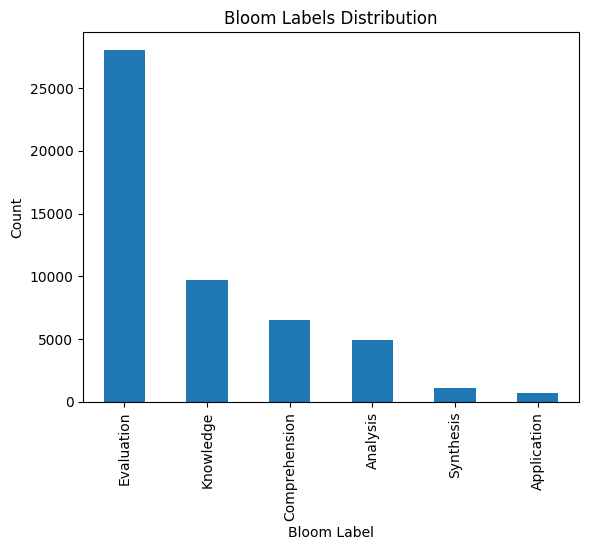

In [27]:
import matplotlib.pyplot as plt
df['bloom_label'].value_counts().plot(kind='bar')
plt.title("Bloom Labels Distribution")
plt.xlabel("Bloom Label")
plt.ylabel("Count")
plt.show()


In [4]:
df = pd.read_json("../Black_White_Hat/dataset_with_bloom.json", lines=True)
df

,turn,utterance,emotion,act,hat,bloom_label,bloom_score
0,0,I'm so angry . I feel like killing someone .,anger,inform,,Evaluation,0.792142
1,1,Calm down . __eou__,no_emotion,inform,,Comprehension,0.512506
2,0,I was just about to go to bed when the telepho...,no_emotion,inform,,Analysis,0.946143
3,1,Who was it ?,no_emotion,question,,Knowledge,0.999966
4,2,Kate . She said she was too excited to go to s...,no_emotion,inform,,Evaluation,0.957235
...,...,...,...,...,...,...,...
50922,5,I felt that the food was pretty mediocre .,no_emotion,inform,,Evaluation,0.999984
50923,6,"The service wasn't that great , either .",no_emotion,inform,,Evaluation,0.999745
50924,7,I agree . The service was not good .,no_emotion,inform,,Evaluation,0.999773
50925,8,Do you think that you want to try this restaur...,no_emotion,question,,Evaluation,0.996227


In [6]:
import matplotlib.pyplot as plt
df['bloom_label'].value_counts()


bloom_label
Evaluation       28039
Knowledge         9695
Comprehension     6513
Analysis          4916
Synthesis         1092
Application        672
Name: count, dtype: int64